#Image Classification with Batch Average Loss Function

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
classes = ['airplane','automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck' ]

In [ ]:
airplane_class = 0
automobile_class = 1
p = 70  # percentage of birds in even batches
q = 30  # percentage of birds in odd batches
train_mask = (y_train == automobile_class) | (y_train == airplane_class)
test_mask = (y_test == automobile_class) | (y_test == airplane_class)

x_train, y_train = x_train[train_mask.squeeze()], y_train[train_mask.squeeze()]
x_test, y_test = x_test[test_mask.squeeze()], y_test[test_mask.squeeze()]


In [ ]:
test = x_train[(y_train == automobile_class).squeeze()]


In [ ]:
def BCCE(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    avg_pred = tf.reduce_mean(y_pred)
    avg_true = tf.reduce_mean(y_true)
    return -tf.reduce_mean(avg_true * tf.math.log(avg_pred + 1e-10) + (1 - avg_true) * tf.math.log(1 - avg_pred + 1e-10))

def create_custom_batches(x, y, batch_size, p, q):
    indices = np.arange(len(x))
    np.random.shuffle(indices)

    bird_indices = np.where(y==1)[0]
    airplane_indices = np.where(y==0)[0]

    for i in range(len(x) // batch_size):

        # determine the target number of birds in the batch based on even or odd batch index
        if i % 2 == 0:
            target_bird_count = int(p / 100 * batch_size)
        else:
            target_bird_count = int(q / 100 * batch_size)

        # separate birds and airplanes within the current batch
        bird_indices = np.where(y == 1)[0]
        airplane_indices = np.where(y == 0)[0]

        # print(i, target_bird_count, bird_indices.shape)

        # sample images
        selected_bird_indices = np.random.choice(bird_indices, target_bird_count, replace=False)
        selected_airplane_indices = np.random.choice(airplane_indices, batch_size - target_bird_count, replace=False)

        # combine selected indices and create the final batch
        final_indices = np.concatenate([selected_bird_indices, selected_airplane_indices])
        np.random.shuffle(final_indices)

        yield x[final_indices], y[final_indices]


def count( y, class_index):
    return np.sum(y == class_index)

def single_batch_statistics(Xbatch, Ybatch):
  class1 = count(Ybatch, class_index =  1)
  class0 = count(Ybatch, class_index = 0)
  total_count = class1 + class0
  return class0/total_count, class1/total_count

def extract_class(X, y, index):
  classlist = []
  labels = []
  for i in range(len(y)): # or X since both have 50,000
   if y[i] == index:
    classlist.append(X[i])
    labels.append(y[i])
  return np.array(classlist), labels


In [ ]:
y_train = np.where(y_train == automobile_class, 1, 0)
y_test = np.where(y_test == automobile_class, 1, 0)

In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
from tensorflow.keras.constraints import MaxNorm
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
    tf.keras.layers.Dense(128, kernel_constraint=MaxNorm(3), activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam', loss=BCCE, metrics=['accuracy'])

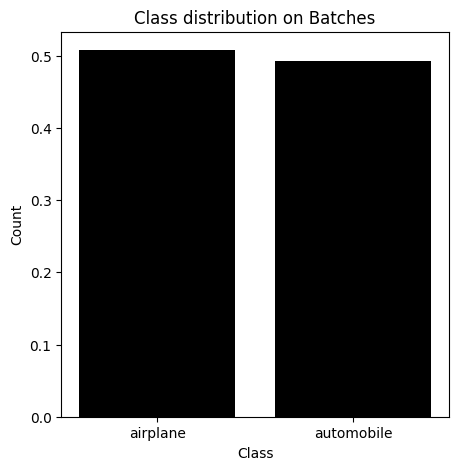

In [ ]:
distribution = []
for batch, ybatch in create_custom_batches(x_train, y_train, 64, p, q):
 distribution.append(single_batch_statistics(batch, ybatch))

names = ['airplane', 'automobile']

distribution = np.array(distribution).sum(axis = 0)

total_distribution = distribution / distribution.sum()

plt.figure(figsize = (5,5))
plt.bar(names, total_distribution, color = 'black')

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class distribution on Batches')
plt.show()


In [ ]:
batch_size = 64
epochs = 4
epoch_loss = 0.0
epoch_acc = 0.0
num_batches = 0
train_losses = []
train_acc = []
avg_mu = []
avg_nu = []
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for batch_x, batch_y in create_custom_batches(x_train, y_train, batch_size, p, q):

       loss , accuracy = model.train_on_batch(batch_x, batch_y)
       train_losses.append(loss)
       train_acc.append(accuracy)

       class0 = batch_x[(batch_y == airplane_class).squeeze()]
       prediction_0 = model.predict(class0)
       mu = np.mean(prediction_0)
       avg_mu.append(mu)

       class1 = batch_x[(batch_y == automobile_class).squeeze()]
       prediction_1 = model.predict(class1)
       nu = np.mean(1 - prediction_1)
       avg_nu.append(nu)





Epoch 1/4
1/1 [==============================] - 0s 31ms/step
Epoch 2/4
1/1 [==============================] - 0s 29ms/step
Epoch 3/4
1/1 [==============================] - 0s 20ms/step
Epoch 4/4
1/1 [==============================] - 0s 18ms/step


In [ ]:
len(avg_nu), len(avg_mu), len(train_losses), len(train_acc)

(624, 624, 624, 624)

In [ ]:
batch_size = 64
epochs = 4
epoch_loss = 0.0
epoch_acc = 0.0
num_batches = 0
for i in range(len(avg_mu)):
  print('mu:' , avg_mu[i], 'nu: ', avg_nu[i], 'accuracy: ', train_acc[i], 'loss: ', train_losses[i])

mu: 0.99996394 nu:  0.00025532057 accuracy:  0.546875 loss:  0.7062324285507202
mu: 0.99391997 nu:  0.011920762 accuracy:  0.296875 loss:  5.991112232208252
mu: 0.81643695 nu:  0.21981287 accuracy:  0.6875 loss:  1.4481016397476196
mu: 0.32672343 nu:  0.6383373 accuracy:  0.296875 loss:  1.2052570581436157
mu: 0.27891332 nu:  0.6680642 accuracy:  0.3125 loss:  0.8501126766204834
mu: 0.2707378 nu:  0.6771204 accuracy:  0.703125 loss:  0.6082413792610168
mu: 0.33424175 nu:  0.64773506 accuracy:  0.3125 loss:  0.9604806900024414
mu: 0.38220266 nu:  0.5909832 accuracy:  0.703125 loss:  0.6131715178489685
mu: 0.4715697 nu:  0.5191667 accuracy:  0.3125 loss:  0.8014135360717773
mu: 0.5180579 nu:  0.48552844 accuracy:  0.65625 loss:  0.6762968301773071
mu: 0.5568658 nu:  0.45430022 accuracy:  0.5625 loss:  0.6837549209594727
mu: 0.5582928 nu:  0.45834962 accuracy:  0.265625 loss:  0.7396084070205688
mu: 0.5732471 nu:  0.44616058 accuracy:  0.6875 loss:  0.6612713932991028
mu: 0.56151646 nu:  

In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

63/63 [==============================] - 0s 2ms/step - loss: 0.6914 - accuracy: 0.7635
Test accuracy: 76.35%


## Testing manually so we can calculate the accuracy for each class

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

63/63 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1000
           1       0.00      0.00      0.00      1000

    accuracy                           0.50      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.50      0.33      2000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
predictions = []
for sample in x_test:
  prediction = model.predict(sample.reshape(1,32,32,3))
  y_pred = 1 if prediction > 0.5 else 0
  predictions.append(y_pred)

1/1 [==============================] - 0s 16ms/step


2000

In [ ]:
print("Classification Report:\n", classification_report(y_test, predictions))

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.78      0.77      1000
           1       0.77      0.75      0.76      1000

    accuracy                           0.76      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.76      0.76      0.76      2000



In [ ]:
print('average training loss:', np.mean(train_losses))
print('average test loss:', np.mean(test_loss))
print('average mu:', np.mean(avg_mu)) # for class 0
print('average nu:', np.mean(avg_nu)) # for class 1
print('average accuracy for training:', np.mean(train_acc))

average training loss: 0.6924991018305986
average test loss: 0.6914159655570984
average mu: 0.43970954
average nu: 0.46369788
average accuracy for training: 0.7037510016025641


In [1]:
readme_content = """
# Image Classification with Batch Average Loss Function


## Description
To learn from a dataset containing images while also preserving privacy can be challenging. This
project presents a framework that utilizes a custom loss function which compares predictions and the
statistics from the batches to help the model learn from the data.

## Dataset
The dataset used for training the model is CIFAR-10: https://www.cs.toronto.edu/~kriz/cifar.html, and is loaded using tensorflow library 'tensorflow.keras.datasets'.
## Installation
No installation is required. The notebook runs on Google Colab with dependencies installed automatically

## Dependencies
Required packages:
 - 'numpy'
 - 'tensorflow'
 - 'matplotlib'
 Run first cell in notebook to install dependencies.

## Usage
1. Open notebook: https://colab.research.google.com/drive/1uYZkF1-OE1b7mcWx836TlA1Z0AW88bOA?usp=sharing

2. Costumize inputs (optional):
   - Adjust the class distribution as needed as long as they remain unbalanced.
   - Batches and epochs can also be modified as needed.

3. Run all cells. GPU usage is recommended for training the model.

## Author

Rina Ahmetaj

## Credits

This project was completed under the supervision of Professor Zhao at Lehman College - CUNY.

"""

with open("README.md", "w") as f:
    f.write(readme_content)

print("README.md created!")

README.md created!
